# Applying the kNN algorithm on a dataset

In this file we're applying the algorithm on a dataset from 'https://archive.ics.uci.edu/dataset' to demonstrate the theory from ***the other file***.  
The two of them works together in this analysis.

From the dataset owner's description:  
   
```
This dataset aims to predict the age of abalone (a type of sea snail) from physical measurements. It includes various attributes like length, diameter, height, whole weight, and other shell measurements.  
The age is determined by the number of rings on the shell + 1.5.
```

To simplify we're predicting the number of rings only.

In [2]:
import numpy as np
import pandas as pd

df_original = pd.read_csv("abalone.data",names= ["Sex","Length","Diameter","Height","Whole weight","Shucked weight","Viscera weight","Shell weight","Rings"])

## Features' description:
- **Sex** / nominal  
    M, F, and I (infant)
    
- **Length** / continuous  
    Longest shell measurement
- **Diameter**	/ continuous  
    perpendicular to length
- **Height** / continuous  
    with meat in shell
- **Whole weight** / continuous  
    whole abalone
- **Shucked weight** / continuous  
    weight of meat
- **Viscera weight** / continuous  
    gut weight (after bleeding)
- **Shell weight** / continuous  
    after being dried
- **Rings** (TARGET) / integer  
    +1.5 gives the age in years

In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [4]:
df_original.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Cleaning the dataset

In [5]:
# Check for missing values
print(df_original.isnull().sum())

Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64


In [6]:
# Check for duplicates
print(df_original.duplicated().sum())

0


In [7]:
from sklearn.calibration import LabelEncoder

# Encode string values
label_encoder = LabelEncoder()
df_original['Sex'] = label_encoder.fit_transform(df_original['Sex'])


In [8]:
# Outliers correction

numerical_cols = df_original.select_dtypes(include=['number']).columns
target = df_original['Rings']

print("Before:", df_original['Sex'].count())

lower_bound = target.quantile(0.05)
upper_bound = target.quantile(0.95)
is_outlier = (target < lower_bound) | (target > upper_bound)
df=df_original[~is_outlier]

print("After:", df['Sex'].count())

Before: 4177
After: 3794


## Splitting
For training and testing. The chosen proportion is 80%-20%.

<div style="text-align:center;">
    <img src="img/split.png" alt="Descrizione dell'immagine" width="300">
</div>

In [9]:
from sklearn.model_selection import train_test_split

X = df.drop('Rings',axis = 1)
y = df['Rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print (X_train.shape, X_test.shape)

(3035, 8) (759, 8)


# Theory in practice - the algorithm
This is the part where we can see the theory of the other file applied.  
We saw:  
### 1. The k-value's choice

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Identify the best k value
param_grid = {'n_neighbors': np.arange(1, 30)}
knn = KNeighborsRegressor()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)

print(f'Best k value: {knn_cv.best_params_}')

Best k value: {'n_neighbors': 15}


Here we chose the value with cross-validation, the standard practice.  
We can be sure that 15 is a value that assures a low computational cost.

### 2. The distance and mean's computation
The method to calculate distance is the 'metric' field in the **KNeighborsRegressor** function.  
The 'weights' field allows to set differents weights to the neighbors.

In [11]:
knn_first_version = KNeighborsRegressor(n_neighbors=knn_cv.best_params_['n_neighbors'],metric='minkowski', p=2, weights='uniform')
knn_first_version.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=15)

The default metric is 'minkowski' which results in euclidean when p is equal 2.  
The default weights function is 'uniform' which does not give any weight to the neighbors.


## Evaluation
We evaluate the performances

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


y_pred = knn_first_version.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Absolute Error: 1.3015371102327624
Mean Squared Error: 3.082746303615868
R-squared: 0.4676418738100535


- MAE : 1.30 $\rightarrow$ On average, the model's predictions are off by 1.30 rings.
    - This results suggest reasonable accuracy with room for improvement.
- MSE: 3.08 $\rightarrow$ This indicates some larger prediction errors.  
    - Some  predictions have significant errors;.
- $\text{R}^2$: 0.47 $\rightarrow$ The model explains 47% of the variability in the number of rings.
    - The model captures less than half of the variance, suggesting the need for a more complex model or additional features. 

We don't know if theese results are optimal, but we can try different combination of k-value, weights and distance's computation. 
   
We start by trying with removing the ouliers in wider (but reasonable) portion.

## Different parameters

In [13]:
numerical_cols = df_original.select_dtypes(include=['number']).columns
target = df_original['Rings']

print("Before:", df_original['Sex'].count())

lower_bound = target.quantile(0.1)
upper_bound = target.quantile(0.9)
is_outlier = (target < lower_bound) | (target > upper_bound)
df_second = df_original[~is_outlier]

print("After:", df_second['Sex'].count())

Before: 4177
After: 3624


In [14]:
X = df_second.drop('Rings',axis = 1)
y = df_second['Rings']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
# k value
param_grid = {'n_neighbors': np.arange(1, 30)}
knn = KNeighborsRegressor()
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)
print(f'Best k value: {knn_cv.best_params_}')
# distance and mean
knn_second_version = KNeighborsRegressor(n_neighbors=knn_cv.best_params_['n_neighbors'],metric='minkowski', p=2, weights='uniform')
knn_second_version.fit(X_train, y_train)
# evaluation
y_pred = knn_second_version.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Best k value: {'n_neighbors': 17}
Mean Absolute Error: 1.1019066937119675
Mean Squared Error: 2.0543467366662687
R-squared: 0.4825508439882732


k value shifted to 17. The evaluation got better results.  
Let's try with weighting the distance.

### Weighted

In [15]:
knn_third_version = KNeighborsRegressor(n_neighbors=knn_cv.best_params_['n_neighbors'],metric='minkowski', p=2, weights='distance')
knn_third_version.fit(X_train, y_train)
# evaluation
y_pred = knn_third_version.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Absolute Error: 1.0963456184783442
Mean Squared Error: 2.0332777311905446
R-squared: 0.48785770816404106


It got slightly better.  
Let's try with different metrics.

### 1. Manhattan distance

In [16]:
knn_fourth_version = KNeighborsRegressor(n_neighbors=knn_cv.best_params_['n_neighbors'],metric='cityblock', weights='distance')
knn_fourth_version.fit(X_train, y_train)
# evaluation
y_pred = knn_fourth_version.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Absolute Error: 1.0901644642301276
Mean Squared Error: 2.036848949570706
R-squared: 0.48695818915696887


### 2. Chebyshev distance

In [17]:
knn_fifth_version = KNeighborsRegressor(n_neighbors=knn_cv.best_params_['n_neighbors'],metric='chebyshev', weights='distance')
knn_fifth_version.fit(X_train, y_train)
# evaluation
y_pred = knn_fifth_version.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Absolute Error: 1.1123282364505906
Mean Squared Error: 2.0711848091310334
R-squared: 0.4783096678371159


### 3. Hamming Distance

In [18]:
knn_seventh_version = KNeighborsRegressor(n_neighbors=knn_cv.best_params_['n_neighbors'],metric='hamming', weights='distance')
knn_seventh_version.fit(X_train, y_train)
# evaluation
y_pred = knn_seventh_version.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Mean Absolute Error: 1.2384663844989932
Mean Squared Error: 2.5625738005643477
R-squared: 0.35453853692119186


## Conclusions

We can see that the third and fourth models are better. Those have k-value=17 and the distances are weighted.  
The third one computes euclidean distance, the fourth one computes manhattan distance.
Let's see the evaluations:

<div style="text-align:center;">
    <img src="img/table_best_distance.PNG" alt="choice" width="350">
</div>

We can conclude that the best combination is the model with a clean dataset that removed the outer deciles, that has a k-value equal to 17, weights the distances and metric set to euclidean distance.

### Now we can visualize the results of the best model:

Mean Absolute Error: 1.0963456184783442
Mean Squared Error: 2.0332777311905446
R-squared: 0.48785770816404106


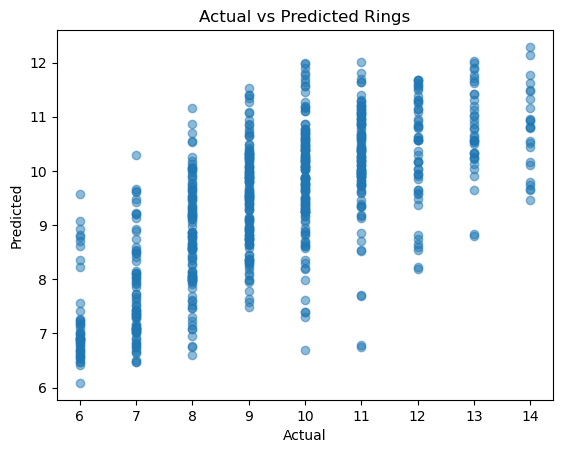

In [19]:
from matplotlib import pyplot as plt

knn_third_version = KNeighborsRegressor(n_neighbors=knn_cv.best_params_['n_neighbors'],metric='minkowski', p=2, weights='distance')
knn_third_version.fit(X_train, y_train)
# evaluation
y_pred = knn_third_version.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Rings')
plt.show()